# Proyecto 1: Analítica de textos

## Miembros
- Estudainte 3: Mariana Pineda Miranda - 202123330
- Estudiante 2: Isaac David Bermúdez- 202014146
- Estudiante 1: Joseph Linares Gutierrez - 202111887

In [18]:
import re
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


pd.set_option('display.max_columns', None)   # todas las columnas
pd.set_option('display.width', None) 

## Perfilamiento y análisis de datos

In [19]:
dataTrain = pd.read_csv("data/train.csv")
dataTest = pd.read_csv("data/test.csv")

In [20]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [21]:
dataTrain['textos'].value_counts()

textos
Aunque existen programas para convertirse específicamente en profesor de lengua materna, o en profesor de SAS (también solo a través del programa de profesor de asignaturas), no están integrados en otros programas de profesorado (Utbildningsdepartementet (Ministerio de Educación e Investigación), 2018,193]). En 2016, el Gobierno creó un comité especial para investigar este asunto. El informe del Comité incluía varias propuestas sobre la forma en que el SAS, la lengua materna y los conocimientos lingüísticos podrían tener una mayor presencia en los programas de formación del profesorado.                                                                                                                                                                                                                                                                                                                                                                                                                

In [22]:
dataTrain['labels'].value_counts()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

In [23]:
dataTrain['textos'].str.len().describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos, dtype: float64

In [24]:
dataTrain.isnull().sum()

textos    0
labels    0
dtype: int64

## Tratamiento de Datos

#### Descarga de las stopwords en español

In [25]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maripinemira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
from nltk.corpus import stopwords

# Lista de stopwords en español
stopwordsInSpanish = stopwords.words('spanish')

print(len(stopwordsInSpanish))
print(stopwordsInSpanish)

313
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están'

#### Limpieza y vectorización de datos

In [27]:
def limpiar_texto(texto: str) -> str:
    texto = texto.lower()                               # Convertir a minusculas
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)       # Eliminar caracteres especiales y numeros
    return texto

dataTrain['texto_limpio'] = dataTrain['textos'].apply(limpiar_texto)

In [28]:
texto_limpio = ' '.join(dataTrain['texto_limpio']).split()

counter = Counter(texto_limpio) # Contar frecuencia
print(counter.most_common(50))

[('de', 22276), ('la', 12254), ('en', 9210), ('los', 8551), ('y', 8101), ('el', 6874), ('que', 5043), ('a', 4768), ('las', 4651), ('para', 3491), ('se', 2897), ('del', 2754), ('un', 2446), ('por', 2237), ('con', 2151), ('una', 2135), ('más', 1797), ('es', 1358), ('como', 1294), ('no', 1226), ('al', 1153), ('salud', 1108), ('pobreza', 1020), ('educación', 995), ('países', 963), ('entre', 962), ('atención', 900), ('o', 798), ('también', 767), ('estudiantes', 742), ('sobre', 674), ('su', 671), ('lo', 629), ('son', 604), ('ocde', 587), ('escuelas', 586), ('años', 560), ('servicios', 549), ('este', 533), ('ha', 523), ('nivel', 521), ('sistema', 508), ('sus', 500), ('sin', 499), ('niños', 481), ('personas', 457), ('pueden', 453), ('calidad', 447), ('han', 437), ('desarrollo', 431)]


#### Adicionar y eliminar stopwords

In [29]:
# Listas de palabras a conservar (eliminar de stopwords)
palabras_de_Negacion = ['no', 'ni', 'nunca', 'jamás', 'tampoco',
                        'sin', 'ningún', 'ninguna', 'ninguno', 
                        'ningunos', 'ningunas', 'nada', 'nadie',
                        'hay', 'había', 'hubo', 'falta', 'faltan',
                        'faltar', 'carecer', 'carecen', 'carencia', 
                        'carencias', 'escasez', 'ausencia', 'inaccesible', 'inaccesibilidad']

palabras_de_poder = ['puedo', 'puede', 'pueden', 'podemos', 'podría', 'podrían']

# Listas de palabras a agregar (adicionar a stopwords)
palabras_conectoras = ['y', 'e', 'además', 'también', 'incluso', 
                       'más', 'pero', 'aunque', 'sino']


stopwordsInSpanish = [w for w in stopwordsInSpanish if w not in palabras_de_Negacion and w not in palabras_de_poder]
stopwordsInSpanish.extend(palabras_conectoras)

print(len(stopwordsInSpanish))
print(stopwordsInSpanish)

315
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sobre', 'también', 'me', 'hasta', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'est

In [30]:
def limpiar_stopword(w):
    return re.sub(r'[^a-záéíóúüñ\s]', '', w.lower())

stopwordsInSpanish = [limpiar_texto(w) for w in stopwordsInSpanish]

vectorizer = TfidfVectorizer(stop_words = stopwordsInSpanish, max_features=5000)
X = vectorizer.fit_transform(dataTrain['texto_limpio'])
y = dataTrain['labels']

## Logistic Regression - Joseph Linares

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print("F1-score promedio:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))

F1-score promedio: 0.9626538895723741
              precision    recall  f1-score   support

           1       0.99      0.90      0.94       101
           3       0.95      0.97      0.96       179
           4       0.96      0.99      0.97       205

    accuracy                           0.96       485
   macro avg       0.97      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



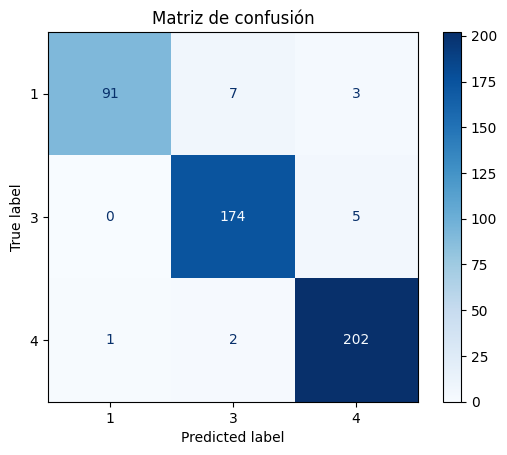

In [32]:
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()

## Naive Bayes - Mariana Pineda Miranda


In [33]:
#Divido mis datos entre test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Algoritmo de Naive Bayes
naive_b = MultinomialNB()
naive_b.fit(X_train, y_train)

y_pred = naive_b.predict(X_test)
y_pred_train = naive_b.predict(X_train)

print("TEST DATA")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train))




TEST DATA
Accuracy: 0.9567010309278351

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.85      0.91       112
           3       0.95      0.99      0.97       168
           4       0.95      0.99      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.94      0.95       485
weighted avg       0.96      0.96      0.96       485


Confusion Matrix:
 [[ 95   7  10]
 [  1 166   1]
 [  1   1 203]]


TRAIN DATA
Accuracy: 0.9804022692109334

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.94      0.97       393
           3       0.98      0.98      0.98       726
           4       0.97      1.00      0.99       820

    accuracy                           0.98      1939
   macro avg       0.98      0.97      0.98      1939
weighted avg       0.98      0.98      0.98      1939


Confusion Matrix:
 [[370  11  12]
 [  3 

## Linear SVM - Mariana Pineda

In [34]:
base = LinearSVC()
clf = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
y_proba = clf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print("TEST DATA")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

TEST DATA
Accuracy: 0.9753
F1-macro: 0.9728

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.96      0.96       112
           3       0.96      0.98      0.97       168
           4       0.99      0.98      0.99       205

    accuracy                           0.98       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.98      0.98      0.98       485


Confusion Matrix:
 [[107   3   2]
 [  3 165   0]
 [  1   3 201]]


TRAIN DATA
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       393
           3       1.00      1.00      1.00       726
           4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939


Confusion Matrix:
 [[393   0   0]
 [  0 726   0]
 